In [1]:
import pickle
data = pickle.load(open('data.pcl','rb'))

import pandas as pd
df = pd.DataFrame(data, columns = ['date', 'player1', 'guild1', 'player2', 'guild2', 'score1', 'score2', 'draw'])
df = df.set_index(df.date)


import trueskill


player = {}
guilds = {}
ratings = {'player': player,
          'guilds': guilds}
env = trueskill.TrueSkill(mu=25.0, sigma=8.333333333333334, beta=4.166666666666667, tau=0.08333333333333334,  draw_probability=0.0, backend=None)

def get_rating(rate_tuple):
    if rate_tuple is None:
        mu = 25.0
        sigma = 8.333333333333334
    else:
        mu = rate_tuple[0]
        sigma = rate_tuple[1]

    return env.Rating(mu, sigma)

def calculate_new_rating(date, winner, winner_guild, loser, loser_guild, draw, ratings):
    winner_rating = get_rating(ratings['player'].get(winner, [None,[None]])[1][-1])
    loser_rating = get_rating(ratings['player'].get(loser, [None,[None]])[1][-1])
    winner_guild_rating = get_rating(ratings['guilds'].get(winner_guild, [None,[None]])[1][-1])
    loser_guild_rating = get_rating(ratings['guilds'].get(loser_guild, [None,[None]])[1][-1])

    t1 = [winner_rating, winner_guild_rating]
    t2 = [loser_rating, loser_guild_rating]
    ranks = [0,1]

    if draw:
        ranks = [0,0]
    (new_w_rating, new_wg_rating),  (new_l_rating, new_lg_rating) = env.rate([t1, t2], 
                                                                                   ranks = ranks, 
                                                                                   weights = [(1.,1.),(1.,1.)])
    
    if winner not in ratings['player']:
        ratings['player'][winner] = [[],[]]
    if loser not in ratings['player']:
        ratings['player'][loser] = [[],[]]
    if winner_guild not in ratings['guilds']:
        ratings['guilds'][winner_guild] = [[],[]]
    if loser_guild not in ratings['guilds']:
        ratings['guilds'][loser_guild] = [[],[]]
        
    ratings['player'][winner][0].append(date)
    ratings['player'][loser][0].append(date)
    ratings['guilds'][winner_guild][0].append(date)
    ratings['guilds'][loser_guild][0].append(date)
    
    ratings['player'][winner][1].append((new_w_rating.mu, new_w_rating.sigma))
    ratings['player'][loser][1].append((new_l_rating.mu, new_l_rating.sigma))
    ratings['guilds'][winner_guild][1].append((new_wg_rating.mu, new_wg_rating.sigma))
    ratings['guilds'][loser_guild][1].append((new_lg_rating.mu, new_lg_rating.sigma))
    
def calculate_new_rating2(date, winner, winner_guild, loser, loser_guild, draw, ratings):
    winner_rating = get_rating(ratings['player'].get(winner, [None,[None]])[1][-1])
    loser_rating = get_rating(ratings['player'].get(loser, [None,[None]])[1][-1])

    t1 = [winner_rating]
    t2 = [loser_rating]
    ranks = [0,1]

    if draw:
        ranks = [0,0]
    (new_w_rating,),  (new_l_rating,) = env.rate([t1, t2], 
                                                                                   ranks = ranks, 
                                                                                   weights = [(1.,),(1.,)])
    
    if winner not in ratings['player']:
        ratings['player'][winner] = [[],[]]
    if loser not in ratings['player']:
        ratings['player'][loser] = [[],[]]
        
    ratings['player'][winner][0].append(date)
    ratings['player'][loser][0].append(date)

    
    ratings['player'][winner][1].append((new_w_rating.mu, new_w_rating.sigma))
    ratings['player'][loser][1].append((new_l_rating.mu, new_l_rating.sigma))
    
for entry in sorted(data, key=lambda x: x[0]):
    calculate_new_rating2(entry[0], entry[1], entry[2], entry[3], entry[4], entry[-1], ratings)

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

def plot_guild(guild): 
    guild_dates = ratings['guilds'][guild][0]
    guild_ratings = [i[0]-3*i[1] for i in ratings['guilds'][guild][1]]
    plt.figure(figsize=(20,10))
    plt.plot(guild_dates,guild_ratings, label = guild)
    plt.show()
def plot_guilds(): 
    plt.figure(figsize=(20,10))
    for guild in ratings['guilds']:
        guild_dates = ratings['guilds'][guild][0]
        guild_ratings = [i[0]-3*i[1] for i in ratings['guilds'][guild][1]]
        plt.plot(guild_dates,guild_ratings, label = guild)
        plt.legend()
    plt.show()
def plot_guilds_sigma(): 
    plt.figure(figsize=(20,10))
    for guild in ratings['guilds']:
        guild_dates = ratings['guilds'][guild][0]
        guild_ratings = [i[1] for i in ratings['guilds'][guild][1]]
        plt.plot(guild_dates,guild_ratings, label = guild)
        plt.legend()
    plt.show()
    
def plot_player(name):
    player_dates = ratings['player'][name][0]
    player_ratings = [i[0] for i in ratings['player'][name][1]]
    player_errors = [i[1] for i in ratings['player'][name][1]]
    player_net_ratings = [i[0]-3*i[1] for i in ratings['player'][name][1]]
    plt.figure(figsize=(20,10))
    plt.title(name)
    plt.errorbar(player_dates,player_ratings, player_errors, label = 'Ratings with Errors')
    plt.plot(player_dates, player_net_ratings, label= '3-Sigma Rating')
    plt.legend()
    plt.show()
    
def get_rankings(ratings):
    rankings = sorted([[i, [round(k,3) for k in j[1][-1]], round(j[1][-1][0]-3*j[1][-1][1],3), len(j[1])] for i,j in ratings['player'].items()], key=lambda x:x[2],reverse=True)
    return rankings

# Number of games per guild in dataset and win ratio

In [3]:
def get_ratio(df, guild, freq):
    a = df[df.guild1==guild].date.groupby(pd.TimeGrouper(freq=freq)).count().rolling(8, center=False).sum()
    b = df[(df.guild1==guild)|(df.guild2==guild)].date.groupby(pd.TimeGrouper(freq=freq)).count().rolling(8, center=False).sum()
    (a/b).plot(label=guild)
guilds = ['The Union', 'Morticians', 'Alchemists', 'Masons', 'Butchers', 'Brewers', 'Hunters', 'Engineers', 'Fishermen']

guild_stats = []
for guild in guilds:
    stat = [guild, df.date[df.guild1==guild].count(), df.date[(df.guild1==guild)|(df.guild2==guild)].count(),
           ]
    stat += [stat[1]/stat[2]]
    guild_stats.append(stat)
pd.DataFrame(guild_stats, columns = ['name', 'wins', 'total games', 'win ratio'])


,name,wins,total games,win ratio
0,The Union,743,1215,0.611523
1,Morticians,897,1690,0.530769
2,Alchemists,813,1511,0.538054
3,Masons,852,1606,0.530511
4,Butchers,1031,1808,0.570243
5,Brewers,738,1523,0.484570
6,Hunters,230,595,0.386555
7,Engineers,520,1099,0.473157
8,Fishermen,989,1823,0.542512


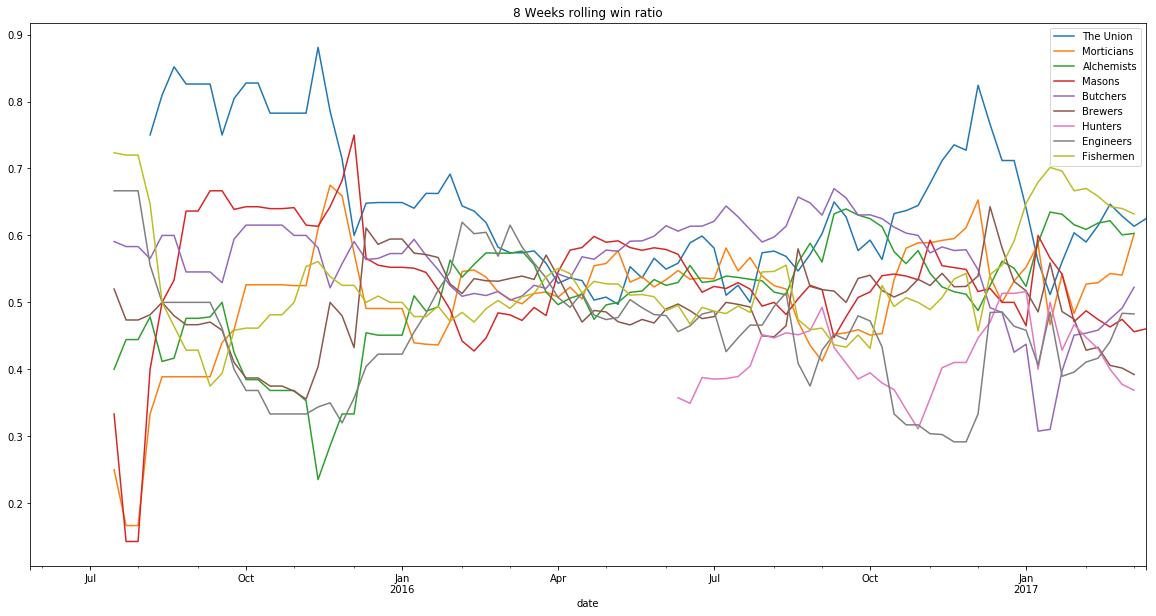

In [4]:

plt.figure(figsize=(20,10))
for guild in guilds:
    get_ratio(df, guild, 'W')
plt.title('8 Weeks rolling win ratio')
plt.legend()

a=0


In [5]:
rankings = get_rankings(ratings)

# Top 50 player ranking using trueskills mu-3sigma as rank

In [17]:
pd.DataFrame(rankings[:50], columns = ['name', '(mu, sigma)', 'mu-3*sigma', '# games'])

,name,"(mu, sigma)",mu-3*sigma,# games
0,Jordan Nach,"[42.87, 1.56]",38.191,62
1,Duane Boyd,"[41.275, 1.573]",36.556,42
2,Alex Botts,"[39.863, 1.426]",35.584,54
3,Patrick Vance,"[41.38, 1.935]",35.575,36
4,Sheridan Plunkett,"[40.225, 1.853]",34.665,33
5,Trent Denison,"[42.729, 2.874]",34.106,18
6,Dutch Adams,"[37.837, 1.444]",33.506,46
7,John Stubbings,"[43.145, 3.245]",33.410,12
8,Steve Newton,"[37.161, 1.368]",33.056,58
9,Brian White,"[43.414, 3.491]",32.942,11
